# Teste de Modelos

Agora, vamos realizar o teste para alguns modelos de regressão e analisar os melhores resultados utilizando a métrica R².

In [107]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

In [108]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score


In [109]:
df = pd.read_csv("dados_tratados.csv", header=0)
df.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Seller_Type_Dealer,Seller_Type_Individual,Novo,Usado,Ano
0,3.35,5.59,27000,0,1,0,1,1,0,1,0,2014
1,4.75,9.54,43000,1,0,0,1,1,0,1,0,2013
2,7.25,9.85,6900,0,1,0,1,1,0,1,0,2017
3,2.85,4.15,5200,0,1,0,1,1,0,1,0,2011
4,4.60,6.87,42450,1,0,0,1,1,0,1,0,2014


In [110]:
data = df.to_numpy()
nrow, ncol = data.shape

X = data[:, 1:ncol]
y = data[:,0]


Antes de testar alguns modelos, vamos normalizar os dados e dividi-los em conjuntos de teste e treino.

In [111]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)


In [112]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Primeiramente, vemos que temos uma coluna "Present Price" com dados bem correlacionados a variável de predição. Então, podemos estimar o score mínimo para que o modelo seja considerado significativo.

In [47]:
present_price = df["Present_Price"]
selling_price = df["Selling_Price"]

score_minimo = r2_score(present_price, selling_price)
print("O score mínimo para os modelos é:", score_minimo)

O score mínimo para os modelos é: 0.568754467416985


Começamos por modelos mais simples, como a regressão linear.

In [113]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

lnr = LinearRegression()
lasso = Lasso()

resultados_lnr = cross_val_score(lnr, x_train, y_train, cv=5, scoring="r2")
resultados_lasso = cross_val_score(lasso, x_train, y_train, cv=5, scoring="r2")

print("Variabilidade para a Regressão Linear", resultados_lnr.mean())
print("Variabilidade para o Lasso", resultados_lasso.mean())

Variabilidade para a Regressão Linear 0.853011496631231
Variabilidade para o Lasso 0.1397568393826189


Obtemos uma estranha diferença entre os métodos Lasso e LinearRegression, podemos avaliar os coeficientes dos mesmos.

In [114]:
def get_score_predict(modelo):

    model = modelo.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score = r2_score(y_test, y_pred)
    return score

print(f"Variabilidade do modelo de Regressão Linear {get_score_predict(lnr)}")
print(f"Variabilidade do modelo de Regressão Lasso {get_score_predict(lasso)}")

Variabilidade do modelo de Regressão Linear 0.8647343653969675
Variabilidade do modelo de Regressão Lasso 0.12996306709389116


Vemos que os coeficentes para o Lasso são muito discrepantes em relação ao modelo de Regressão Linear, o qual obteve um bom score.

Podemos também testar um modelo de regressão polinomial.

In [115]:
import warnings
warnings.filterwarnings("ignore")

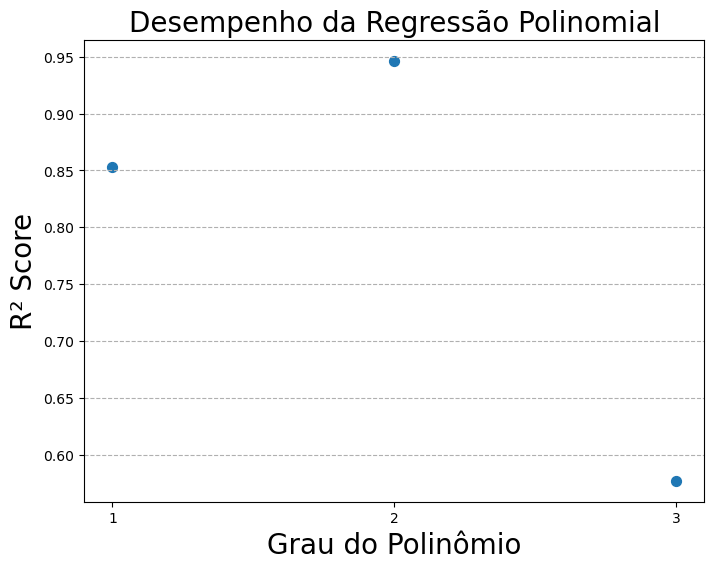

In [116]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


score = []
grau = np.arange(1,5,1)

for i in grau:
     resultados = []
     poly_rg = PolynomialFeatures(degree=i, include_bias=False)
     x_poly = poly_rg.fit_transform(x_train)
     resultados_lnr = (cross_val_score(lnr, x_poly, y_train, cv=5, scoring="r2"))
     for i in resultados_lnr:
        if i < 1 and i > 0:
            resultados.append(i)
     score.append(np.mean(resultados))


plt.figure(figsize=(8, 6))
plt.scatter(grau,score, s=50)
plt.title('Desempenho da Regressão Polinomial', fontsize=20)
plt.xlabel('Grau do Polinômio', fontsize=20)
plt.ylabel('R² Score', fontsize=20)
plt.xticks(np.arange(1,4, 1))
plt.grid(True, axis="y", linestyle= "--" )

plt.show()

Vemos que o polinômio de segundo grau obteve um resultado melhor comparado à Regressão Linear.

In [117]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

poly_rg = PolynomialFeatures(degree=2)
lnr_poly = LinearRegression()
ridge_poly = Ridge()

x_poly = poly_rg.fit_transform(x_train)
x_poly_test = poly_rg.fit_transform(x_test)

def get_score_predict(modelo):

    model = modelo.fit(x_poly, y_train)
    y_pred = model.predict(x_poly_test)
    score = r2_score(y_test, y_pred)

    return score

print("Variabilidade da Regressão Polinomial de grau 2 com LinerRegression:", get_score_predict(lnr_poly))
print("Variabilidade da Regressão Polinomial de grau 2 com Ridge:", get_score_predict(ridge_poly))


Variabilidade da Regressão Polinomial de grau 2 com LinerRegression: 0.952075483889793
Variabilidade da Regressão Polinomial de grau 2 com Ridge: 0.9256728095714356


Agora, vamos testar modelos de K vizinhos, estudando alguns hiperparâmetros possíveis de maximização do resultado.

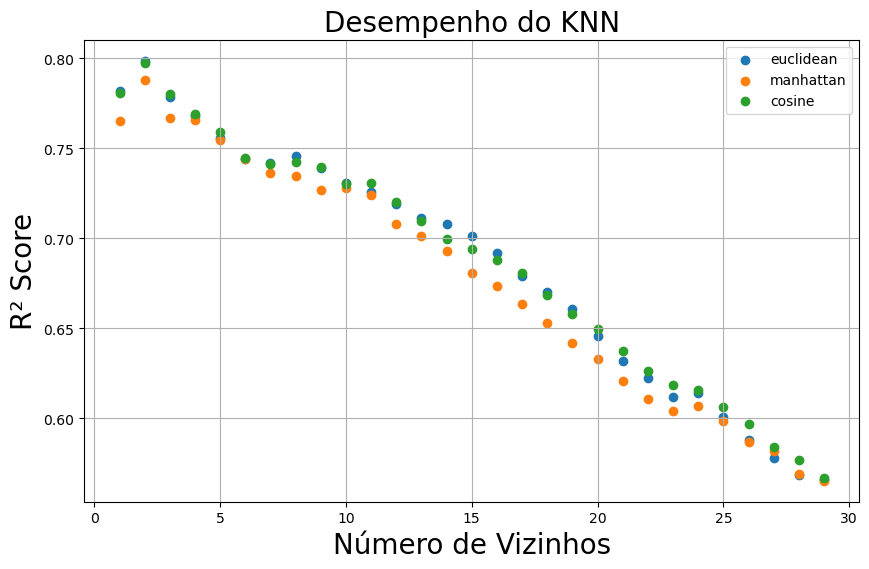

In [94]:
from sklearn.neighbors import KNeighborsRegressor

dist = ["euclidean", "manhattan", "cosine"]
n_neighbors = range(1, 30)

resultados = {d: [] for d in dist} 

for i in dist:
    for j in n_neighbors:
        knn = KNeighborsRegressor(n_neighbors=j, metric=i)
        resultados_knn = cross_val_score(knn, x_train, y_train, cv=5, scoring="r2")
        score = resultados_knn.mean()
        resultados[i].append(score)


plt.figure(figsize=(10, 6))
for d in dist:
    plt.scatter(list(n_neighbors), resultados[d], label=d)

plt.title('Desempenho do KNN', fontsize=20)
plt.xlabel('Número de Vizinhos', fontsize=20)
plt.ylabel('R² Score', fontsize=20)
plt.legend()
plt.grid(True)


plt.show()

Assim, vemos que para o método de distância "Euclidean" e "Cosine" a melhor quantidade de vizinhos são 2. Então, podemos testar a eficácia do modelo em prever o conjunto de teste.

In [95]:
knn = KNeighborsRegressor(n_neighbors=2, metric="euclidean")

model_knn = knn.fit(x_train,y_train)

y_pred_knn = model_knn.predict(x_test)

score_knn = r2_score(y_pred_knn,y_test)

print("Variabilidade para o K vizinhos", score_knn)


Variabilidade para o K vizinhos 0.9054273869397989


Vamos estudar o modelo Random Forest.

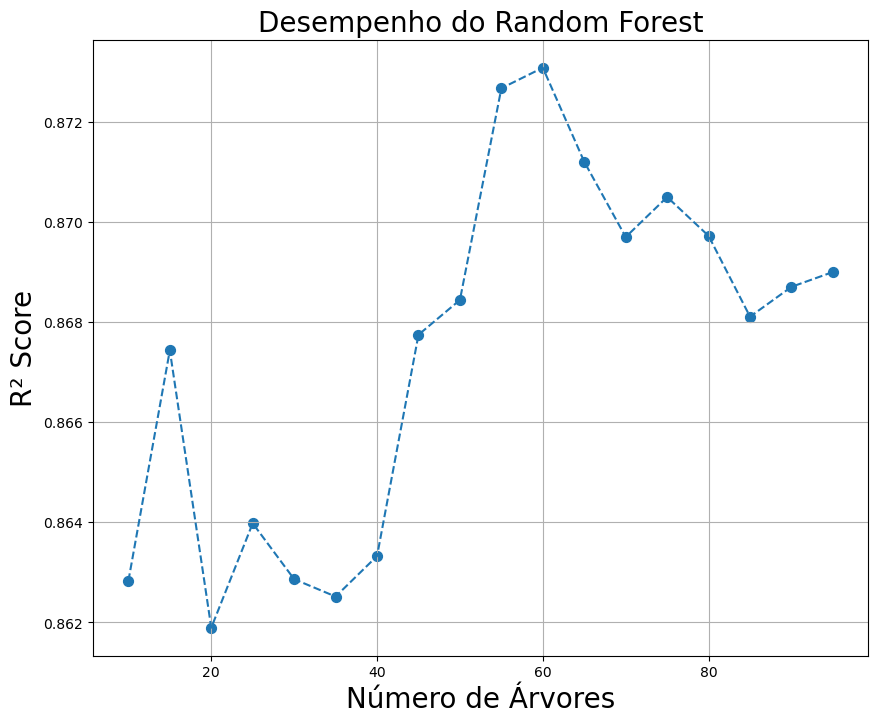

In [96]:
from sklearn.ensemble import RandomForestRegressor

n_estimator = range(10,100,5)
score_rf = []

for i in n_estimator:

    rf = RandomForestRegressor(n_estimators=i, random_state=30)
    resultados_rf = cross_val_score(rf, x_train, y_train, cv=5, scoring="r2")

    score_rf.append(resultados_rf.mean())

plt.figure(figsize=(10,8))
plt.scatter(n_estimator, score_rf, s=50,marker='o')
plt.plot(n_estimator, score_rf, "--")
plt.title("Desempenho do Random Forest", fontsize=20)
plt.ylabel("R² Score", fontsize=20)
plt.xlabel("Número de Árvores", fontsize=20)
plt.grid(True)
plt.show()

    


Vemos que a quantidade de árvores que maximiza o modelo de Random Forest para os dados de treino é 60, vamos medir a variabilidade do mesmo para o conjunto de teste.

In [97]:
rf = RandomForestRegressor(n_estimators=60, random_state=30)

model_rf = rf.fit(x_train,y_train)

y_pred_rf = model_rf.predict(x_test)

score_rf = r2_score(y_test, y_pred_rf)

print("Variabilidade do Random Forest", score_rf)

Variabilidade do Random Forest 0.9640807374219673


Ainda, podemos analisar as colunas de maior importância no modelo.

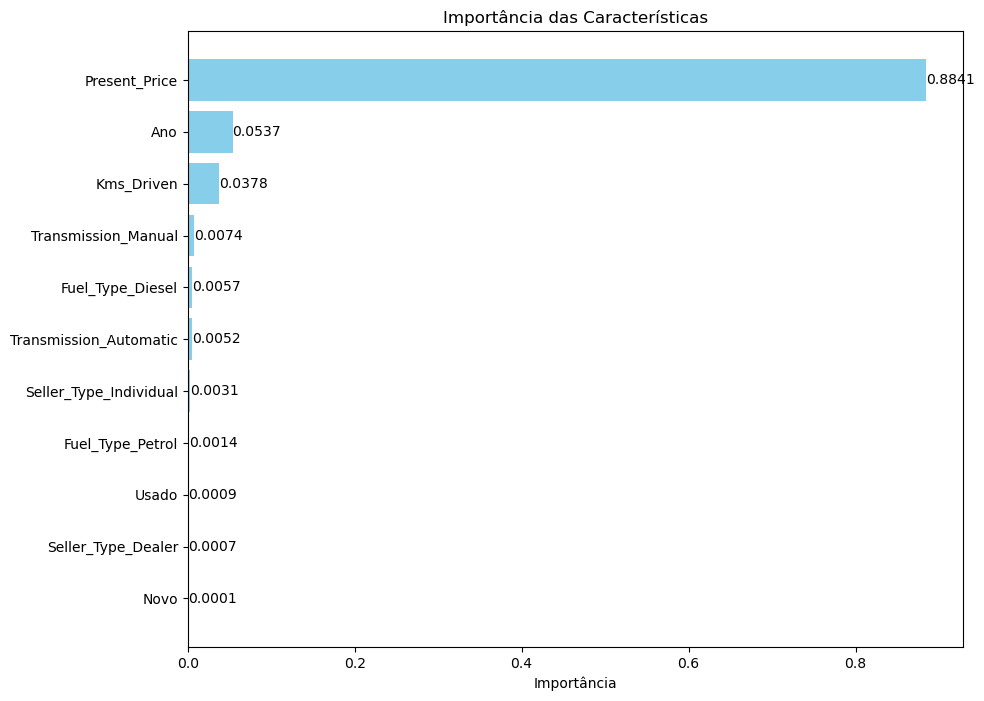

In [98]:
f_importance = model_rf.feature_importances_

df_aux = df.drop("Selling_Price", axis=1)
features = df_aux.columns

lista = list(zip(features, f_importance))
lista.sort(key=lambda x: x[1])  # Ordenando a lista pelo valor da importância

features_ordered = [x[0] for x in lista]
importance_ordered = [x[1] for x in lista]

color = ["lightseagreen"]

plt.figure(figsize=(10, 8))
bars = plt.barh(features_ordered, importance_ordered, color='skyblue')
plt.xlabel('Importância')
plt.title('Importância das Características')

# Adicionando os valores das importâncias nas barras
for index, value in enumerate(importance_ordered):
    plt.text(value, index, f'{value:.4f}', ha='left', va='center', fontsize=10, color='black')

plt.show()

Observamos que a coluna "Present Price" é responsável por boa parte da predição, porém, comparado com o valor mínimo de score estabelido, notamos que o modelo possa estar superestimando esta informação.

Podemos excluir as colunas desnecessária para avaliar o desempenho do modelo.

In [99]:
df_test = df.drop(["Novo", "Seller_Type_Dealer", "Usado", "Fuel_Type_Petrol", "Seller_Type_Individual"], axis=1)
df_test.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type_Diesel,Transmission_Automatic,Transmission_Manual,Ano
0,3.35,5.59,27000,0,0,1,2014
1,4.75,9.54,43000,1,0,1,2013
2,7.25,9.85,6900,0,0,1,2017
3,2.85,4.15,5200,0,0,1,2011
4,4.60,6.87,42450,1,0,1,2014


In [100]:
data = df_test.to_numpy()
nrow, ncol = data.shape

X = data[:, 1:ncol]
y = data[:,0]

In [101]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

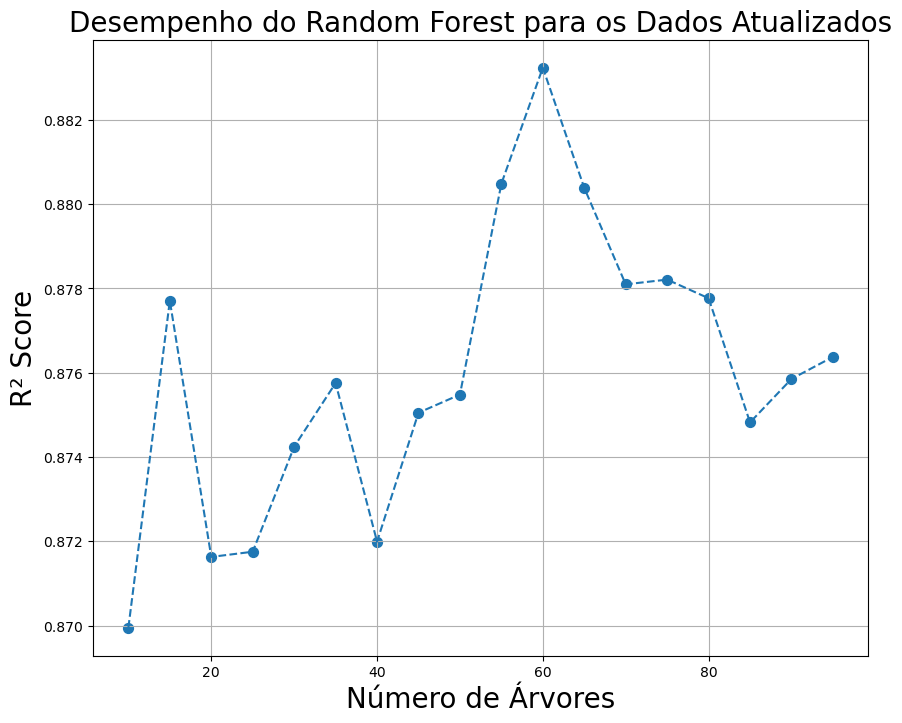

In [102]:
from sklearn.ensemble import RandomForestRegressor

n_estimator = range(10,100,5)
score_rf = []

for i in n_estimator:

    rf = RandomForestRegressor(n_estimators=i, random_state=30)
    resultados_rf = cross_val_score(rf, x_train, y_train, cv=5, scoring="r2")

    score_rf.append(resultados_rf.mean())

plt.figure(figsize=(10,8))
plt.scatter(n_estimator, score_rf, s=50,marker='o')
plt.plot(n_estimator, score_rf, "--")
plt.title("Desempenho do Random Forest para os Dados Atualizados", fontsize=20)
plt.ylabel("R² Score", fontsize=20)
plt.xlabel("Número de Árvores", fontsize=20)
plt.grid(True)
plt.show()


In [103]:
rf = RandomForestRegressor(n_estimators=60, random_state=30)

model_rf_teste = rf.fit(x_train,y_train)

y_pred_rf = model_rf_teste.predict(x_test)

score_rf = r2_score(y_test, y_pred_rf)

print("Variabilidade do Random Forest", score_rf)

Variabilidade do Random Forest 0.9619249670744916


Vemos que estas alterações não impactaram a variabilidade, talvez realizando algumas modificações na estrutura dos dados e estudando algumas variáveis a mais dos modelos podemos alcançar melhores resultados, apesar de todos eles terem batido o score mínimo estabelecido.